In [1]:
# import library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

train = pd.read_parquet(Path('../data/interim/train_merged.parquet'))
print(f'Data loaded: {train.shape}')

Data loaded: (590540, 434)


In [2]:
# overal missing value

missing = train.isnull().sum()
missing_pct = (missing/ len(train) * 100).sort_values(ascending=False)

# filter to columns with missing 
cols_missing = missing_pct[missing_pct > 0]

print('Missing Overview :')
print(f'total Columns : {len(train.columns)}')
print(f'columns with missing : {len(cols_missing)} ({len(cols_missing) / len(train.columns)*100:.1f}%)')
print(f'0% missing : {(missing_pct == 0).sum()} %')
print(f'1-10% missing {((missing_pct > 0) & (missing_pct <= 10)).sum()} columns')
print(f'10-50% missing:{((missing_pct > 10) & (missing_pct <= 50)).sum()} columns')
print(f'50-90% missing:{((missing_pct > 50) & (missing_pct <= 90)).sum()} columns')
print(f'>90% missing:  {(missing_pct > 90).sum()} columns')

Missing Overview :
total Columns : 434
columns with missing : 414 (95.4%)
0% missing : 20 %
1-10% missing 92 columns
10-50% missing:108 columns
50-90% missing:202 columns
>90% missing:  12 columns


In [3]:
# misisng by column group
col_group = {
    'Core' : ['TransactionId', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD'],
    'Card' : [c for c in train.columns if c.startswith('card')],
    'Address' : ['addr1', 'addr2' , 'dist1', 'dist2'],
    'Email' : ['P_emaildomain', 'R_emaildomain'],
    'C (Count)' : [c for c in train.columns if c.startswith('C') and c[1:].isdigit()],
    'D (Timedelta)' : [c for c in train.columns if c.startswith('D') and c[1:].isdigit()],
    'M (Match)': [c for c in train.columns if c.startswith('M') and c[1:].isdigit()],
    'V (Vesta)': [c for c in train.columns if c.startswith('V') and c[1:].isdigit()],
    'Identity': [c for c in train.columns if c.startswith('id_') or c in ['DeviceType', 'DeviceInfo']]
}

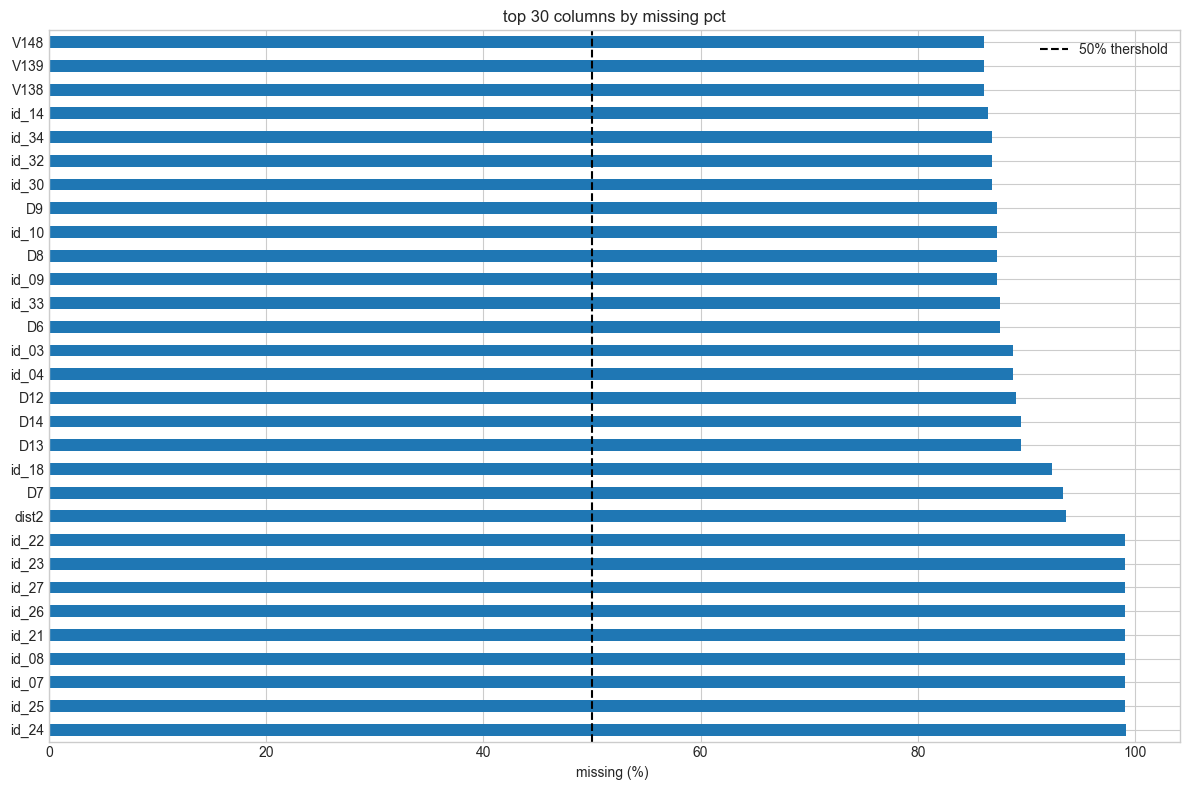

In [4]:
# visualize missing pattern
top_missing = missing_pct.head(30)

fig, ax = plt.subplots(figsize=(12,8))
top_missing.plot(kind='barh', ax=ax)
ax.set_title('top 30 columns by missing pct')
ax.set_xlabel('missing (%) ')
ax.axvline(x=50, color='black', linestyle='--', label='50% thershold')
ax.legend()
plt.tight_layout()
plt.show()

## CORREALTION MISSING WITH FRRAUD ANALYSIS


In [8]:
# calculate fr for missing vs non missing
results = []

for col in cols_missing.index[:30]:
    mask_missing = train[col].isnull()
    
    fraud_missing = train.loc[mask_missing, 'isFraud'].mean() * 100
    fraud_present = train.loc[~mask_missing, 'isFraud'].mean() * 100
    
    results.append({
        'columns' : col,
        'missing_pct' : missing_pct[col],
        'fraud_missing' : fraud_missing,
        'fraud_present' : fraud_present,
        'fraud_diff' : fraud_missing - fraud_present
    })
    
missing_fraud_df = pd.DataFrame(results)
print('fraud rate : missing vs present : ')
print(missing_fraud_df.sort_values('fraud_diff', ascending=False).head(15))

fraud rate : missing vs present : 
   columns  missing_pct  fraud_missing  fraud_present  fraud_diff
23   id_30    86.865411       3.357084       4.437568   -1.080485
24   id_32    86.861855       3.355467       4.447967   -1.092501
28    V139    86.123717       3.345098       4.454207   -1.109109
27    V138    86.123717       3.345098       4.454207   -1.109109
29    V148    86.123717       3.345098       4.454207   -1.109109
26   id_14    86.445626       3.346549       4.471291   -1.124742
25   id_34    86.824771       3.350269       4.479147   -1.128878
18   id_33    87.589494       3.344604       4.588683   -1.244079
1    id_25    99.130965       3.458443       8.125487   -4.667044
5    id_26    99.125715       3.457259       8.231648   -4.774389
7    id_23    99.124699       3.457124       8.241439   -4.784316
8    id_22    99.124699       3.457124       8.241439   -4.784316
6    id_27    99.124699       3.457124       8.241439   -4.784316
4    id_21    99.126393       3.457065   

In [ ]:
# visualize fr by missing

top_diff = missing_fraud_df.nlargest(10, 'fraud_diff')

fig, ax = plt.subplots(figsize = (12, 6))
x = range(len(top_diff))
width = 0.35
ax.bar([i - width/2 for i in x], top_diff['fraud_present'], width, label='Present', color='red')
ax.bar([i + width/2 for i in x], top_diff['fraud_when_missing'], width, label='Missing', color='blue')
ax.set_xticks(top_diff['column'], rotation=45, ha='right')
ax.set_ylabel('Fraud Rate (%)')
ax.set_title('Fraud Rate: Missing vs Present (Top 10 Difference)', fontsize=12)
ax.legend()
plt.tight_layout()
plt.show()
